In [1]:
#Import package
import pandas as pd 
import seaborn as sns
import nltk
import re
import gensim
from gensim import corpora
from gensim import similarities
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


C:\Users\sasha\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
top10k = pd.read_csv('restaurant_cleaned (1).csv')


In [3]:
docs = top10k['text'].apply(word_tokenize)



In [4]:
d = gensim.corpora.Dictionary(docs)

#convert docs to vec
v = [d.doc2bow(doc) for doc in docs]


In [6]:
#Represent as tfidf matrix of Restaurant reviews

wordlist = top10k.text.values.tolist()

vectorizer= CountVectorizer()
reviews_vecs=vectorizer.fit_transform(wordlist)
reviews_vecs
feature_names = vectorizer.get_feature_names()
feature_names

reviews_lda = LatentDirichletAllocation(n_components=4,               
                                      learning_method='online',   
                                      n_jobs = -1)              
lda_output = reviews_lda.fit_transform(reviews_vecs)

lda_output

array([[0.01388827, 0.0141912 , 0.01369063, 0.9582299 ],
       [0.20728934, 0.00332347, 0.00349696, 0.78589023],
       [0.00400038, 0.07643217, 0.05920108, 0.86036637],
       ...,
       [0.16615756, 0.82365078, 0.00521478, 0.00497688],
       [0.13136762, 0.84084252, 0.01398338, 0.01380648],
       [0.06630402, 0.67001429, 0.26063936, 0.00304232]])

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(reviews_lda,feature_names, 10)

Topic 0:
ramen noodl egg pork delici dish tast brunch order sauc
Topic 1:
order servic restaur time tabl dish come back friend wait
Topic 2:
fri burger pork mi banh kimchi chicken order chees bao
Topic 3:
sandwich smoke wait line montreal order time eat schwartz take


In [8]:
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
perplexity_values = []
model_topics = []

for num_topics in range(2, 10, 2):
    reviews_lda_x = LatentDirichletAllocation(n_components=num_topics, learning_method='online', n_jobs = -1)
    reviews_lda_x.fit_transform(reviews_vecs)
    model_topics.append(num_topics)
    model_list.append(reviews_lda_x)
    perplexity_values.append(reviews_lda_x.perplexity(reviews_vecs))
    print("#Topics: " + str(num_topics) + ", Score: " + str(reviews_lda_x.perplexity(reviews_vecs)))

print(datetime.datetime.now())

2020-04-13 20:56:49.314908
#Topics: 2, Score: 1920.7642905668936
#Topics: 4, Score: 1886.6439316269116
#Topics: 6, Score: 1908.5054693760428
#Topics: 8, Score: 1955.2763108510485
2020-04-13 21:06:34.451335


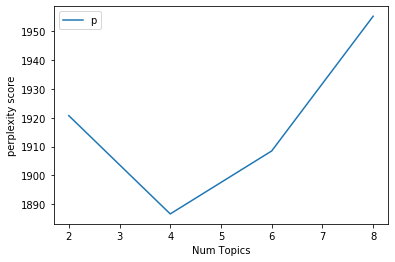

In [9]:
#print("Perplexity: ", reviews_lda.perplexity(reviews_vecs))
import matplotlib.pyplot as plt

limit=10; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [15]:
# Create Document - Topic Matrix
#I choose model_list[2] where the number of topics is 6
lda_output = model_list[2].transform(reviews_vecs)

# column names
topicnames = ["Topic" + str(i) for i in range(model_list[2].n_components)]

# index names
docnames = [str(i) for i in docs]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 5), columns=topicnames, index=docnames)

# # Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# """"""
# # Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
num_doc_to_show = 100  # change this to display the number of documents shown below
df_document_topics = df_document_topic.head(num_doc_to_show)

dominant_topic = df_document_topic['dominant_topic']

top10k['topic'] = list(dominant_topic)


topic_dict = {1:'Asian Food', 2:'Service', 3:'Time',
             4:'French'}

top_10k = top10k.replace({'topic':topic_dict})
top_10k



,Unnamed: 0,review_id,user_id,business_id,stars_x,date,text,useful,funny,cool,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,categories,lang,topic
0,0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,super simpl amaz nonetheless around sinc 30 st...,0,0,0,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
1,1,vm1b1keOzwHjtGZEPPuYXA,xYciRtVZ1PW4IxSX4oJ1aw,AEx2SYEUJmTxVVB18LlCwA,5,2016-02-22,shop featur mind chef anthoni bourdain david c...,4,3,4,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,French
2,2,SXwA9KZ-Nc_hMARk_3cJ7g,5Ymfsf9fAYz-Ds_p0xawVQ,AEx2SYEUJmTxVVB18LlCwA,5,2013-03-29,name suggest wilenski lunch counteron that ope...,9,0,3,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
3,3,jUzausdZ_ujqe_n8BlBj-g,DVOOF0Z627DyrZ4XKQbTgA,AEx2SYEUJmTxVVB18LlCwA,5,2017-08-08,stop wilenski special love almost shed tear ta...,0,0,0,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
4,4,oCRDwF3tszAkeszSfxwthg,5JoKz3mU42Cp906KRXDwJw,AEx2SYEUJmTxVVB18LlCwA,4,2009-01-17,admit fan enter know time stop mani mani year ...,4,0,1,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
5,5,TYphpVifQtoO1IXkTKtf8w,XYjB4jCthoDf1aeFG16tNA,AEx2SYEUJmTxVVB18LlCwA,5,2015-06-20,went visit montreal simpl yet delici special c...,0,0,0,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,French
6,6,c1q_TI2ngewvxl7hABbRog,WxSV-4GoqPCczNn4RsU5ew,AEx2SYEUJmTxVVB18LlCwA,1,2017-08-23,disgust compon hotdog handl three separ peopl ...,0,0,0,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
7,7,oaF1-IpDRZ9HkSeokHyjkA,NPi4JDCRwA9MiuR2kOQrWw,AEx2SYEUJmTxVVB18LlCwA,5,2016-09-30,70 year make signatur sandwich way take serv s...,1,1,1,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
8,8,3X78HuYLgt5DcDQpb7d7XA,NGLufCod1pP760aBucp3tw,AEx2SYEUJmTxVVB18LlCwA,3,2016-07-26,hear mani thing fame variou critic person fina...,1,1,0,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service
9,9,9aM9CDxBNanGyQvW86JtuA,mYQmaTeWp87sGnE-rHvIOw,AEx2SYEUJmTxVVB18LlCwA,5,2013-12-30,wilenski import remind montreal heritag wilens...,3,1,1,...,QC,H2T 2M1,45.523333,-73.594859,4.0,84,1,"['Diners', 'Food', 'Restaurants', 'Delis']",en,Service


In [20]:
# top10k = top10k.drop(['doc_topics'], axis = 1)



SyntaxError: invalid syntax (<ipython-input-20-a44912e413ca>, line 3)

In [25]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
visual = pyLDAvis.sklearn.prepare(reviews_lda, reviews_vecs, vectorizer, mds='tsne')
pyLDAvis.save_html(visual, "topic_viz_sklearn3.html")


KeyboardInterrupt: 

In [18]:
import joblib
#Save a model to disk, or reload a pre-trained model

reviews_lda=model_list[1]
joblib.dump(reviews_lda, 'reviews_lda.jl')

# # then reload it with
lda_disk = joblib.load('reviews_lda.jl')


In [21]:
import pandas as pd
df_document_topics.to_csv("doc_topic.csv")

AttributeError: 'Styler' object has no attribute 'to_csv'